### generate synthetic training dataset

Text(0, 0.5, '$\\rho_k$')

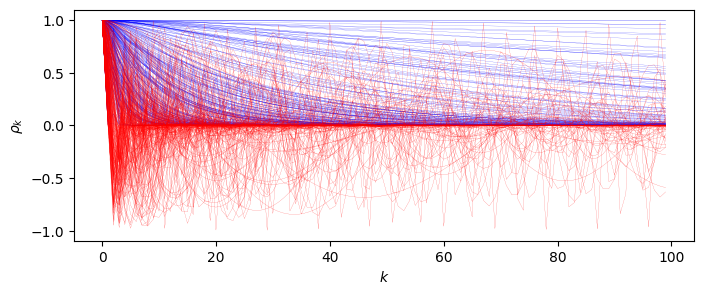

In [1]:
import matplotlib.pyplot as plt
import nb_utils
import numpy as np
from src import acf_utils

n_lags, n_repeats = 100, 500

X_acf = np.zeros(shape=(n_lags, n_repeats))
labels = np.zeros(shape=n_repeats)
for idx in range(n_repeats):
    label = idx % 2
    labels[idx] = label
    phis = nb_utils.gen_ar2_coeffs(oscillatory=label, random_seed=idx)
    X_acf[:, idx] = acf_utils.ar_to_acf(phis, n_lags=n_lags)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_acf[:, labels == 0], lw=0.1, c="b")
ax.plot(X_acf[:, labels == 1], lw=0.1, c="r")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\rho_k$")

In [2]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from sklearn.decomposition import PCA

embedder = TakensEmbedding(time_delay=1, dimension=5)

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True)

steps = [
    ("embedder", embedder),
    ("pca", batch_pca),
    ("persistence", persistence),
    ("scaling", scaling),
    ("entropy", entropy),
]
topological_transfomer = Pipeline(steps)

In [3]:
features = topological_transfomer.fit_transform(X_acf.T)

In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.1, random_state=0
)


def get_accuracy(model):
    return (
        f"Accuracy on train: {accuracy_score(model.predict(X_train), y_train):.3f}",
        f"ROC AUC on train: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]):.3f}",
        f"Accuracy on valid: {accuracy_score(model.predict(X_valid), y_valid):.3f}",
        f"ROC AUC on valid: {roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]):.3f}",
    )

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
get_accuracy(model)

('Accuracy on train: 0.827',
 'ROC AUC on train: 0.796',
 'Accuracy on valid: 0.840',
 'ROC AUC on valid: 0.781')